<a href="https://colab.research.google.com/github/akhanf/funcmasker-compare/blob/master/analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

sns.set_context("talk")


In [2]:
df = pd.read_csv('https://github.com/akhanf/funcmasker-compare/raw/master/funcmasker_output/test_dice.csv')
#sns.displot(df,x='dice')

df.set_index('id')

,voxels_manual,voxels_auto,voxels_overlap,dice,jaccard
id,,,,,
sub-2006_ses-T1_task-rest_vol-0,8237,7594,7170,0.905818,0.827849
sub-2006_ses-T1_task-rest_vol-1,8485,7683,7327,0.906358,0.828752
sub-2006_ses-T1_task-rest_vol-2,8622,7538,7365,0.911510,0.837408
sub-2006_ses-T1_task-rest_vol-3,8847,7618,7482,0.908837,0.832907
sub-2006_ses-T1_task-rest_vol-4,8779,7615,7396,0.902281,0.821960
...,...,...,...,...,...
sub-2228_ses-T2_task-rest_vol-1,9228,8735,8615,0.959194,0.921588
sub-2228_ses-T2_task-rest_vol-2,9324,8789,8674,0.957765,0.918953
sub-2228_ses-T2_task-rest_vol-3,9325,8993,8749,0.955235,0.914307


### IMPORTANT NOTE:
In the Rutherford dataset there are some images where the raw data (manual mask) is incorrect -- I previously examined the auto and manual masks and found that any masks where our Dice was < 0.7 were actually bad data, so removed based on that criteria, and also make a list that noted additional bad data (`bad_vols.txt`) but I can't find that list anymore.. 

This code used the `bad_vols.txt` to exclude that data:
```
#get list of bad volumes (those where manual mask extends past the bold -- bids dataset has incorrect cropping for some subjects that causes this)

df_bad = pd.read_table('../test_rutherford_brainmask/bad_vols.txt',
                      sep=' ',names=['subject','session','task','vol'])
df_bad

def map_vol(vol):
    return f'vol-{vol}'

bad_ids = ['_'.join(i) for i in zip(df_bad['subject'].map(str),df_bad['session'].map(str),df_bad['task'].map(str),df_bad['vol'].map(map_vol))]

df_bad = pd.DataFrame(bad_ids,columns=['id'])
df_bad


df = (pd.merge(df,df_bad, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1))
```

I still include the original 0.7 Fice filter here too below, but ideally we should just be throwing out the bad manual masks based on visual inspection only.. 

In [3]:
#have confirmed that Dice <0.7 are errors in manual seg

df3d = df[df['dice'] > 0.7 ]

# if you want to avoid this filter, use the following:
df3d = df

In [4]:
df2d = pd.read_csv('https://github.com/akhanf/funcmasker-compare/raw/master/funcmasker_output/test_rutherfordunet_dice.csv')
df = pd.merge(df3d,df2d,left_on='id',right_on='id',suffixes=('_nnunet','_rutherford'))

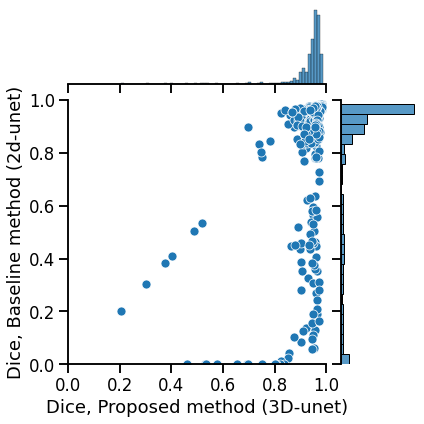

In [5]:
df
g = sns.jointplot(x='dice_nnunet',y='dice_rutherford',data=df,xlim=(0,1),ylim=(0,1),ratio=3,n)
#g.set_xlabel("Dice score, Baseline method (2d-unet)", fontsize = 20)
g.set_axis_labels("Dice, Proposed method (3D-unet)", "Dice, Baseline method (2d-unet)")

g.savefig('figures/dice_scatter_ds3090.svg')

In [6]:
#make table with mean, stdev, and range
print("\\begin{tabular}{|c|c|c|}")
print(f"Dice metric & $\mu \pm  \sigma$  & (min, max) \\\\")
print(f" Proposed method (3D-unet) & ${df['dice_nnunet'].mean():0.2f} \pm {df['dice_nnunet'].std():0.2f}$ & $({df['dice_nnunet'].min():0.2f},{df['dice_nnunet'].max():0.2f} )$ \\\\")
print(f" Baseline method (2D-unet) & ${df['dice_rutherford'].mean():0.2f} \pm {df['dice_rutherford'].std():0.2f}$ & $({df['dice_rutherford'].min():0.2f},{df['dice_rutherford'].max():0.2f} )$ \\\\")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|}
Dice metric & $\mu \pm  \sigma$  & (min, max) \\
 Proposed method (3D-unet) & $0.92 \pm 0.10$ & $(0.21,0.99 )$ \\
 Baseline method (2D-unet) & $0.79 \pm 0.28$ & $(0.00,0.99 )$ \\
\end{tabular}


In [7]:
#make table with mean, stdev, and range
print("\\begin{tabular}{|c|c|c|}")
print(f"Dice metric & $\mu \pm  \sigma$  & (min, max) \\\\")
print(f" Proposed method (3D-unet) & ${df['dice_nnunet'].mean():0.2f} \pm {df['dice_nnunet'].std():0.2f}$ & $({df['dice_nnunet'].min():0.2f},{df['dice_nnunet'].max():0.2f} )$ \\\\")
print(f" Baseline method (2D-unet) & ${df['dice_rutherford'].mean():0.2f} \pm {df['dice_rutherford'].std():0.2f}$ & $({df['dice_rutherford'].min():0.2f},{df['dice_rutherford'].max():0.2f} )$ \\\\")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|}
Dice metric & $\mu \pm  \sigma$  & (min, max) \\
 Proposed method (3D-unet) & $0.92 \pm 0.10$ & $(0.21,0.99 )$ \\
 Baseline method (2D-unet) & $0.79 \pm 0.28$ & $(0.00,0.99 )$ \\
\end{tabular}


In [8]:
#make vert concat table
group = ['Proposed (3D-unet)' for i in range(len(df3d))] + ['Baseline (2D-unet)' for i in range(len(df3d))]
df = pd.DataFrame(pd.concat((df['dice_nnunet'],df['dice_rutherford']),ignore_index=True),columns=['dice'])
df['group']=group

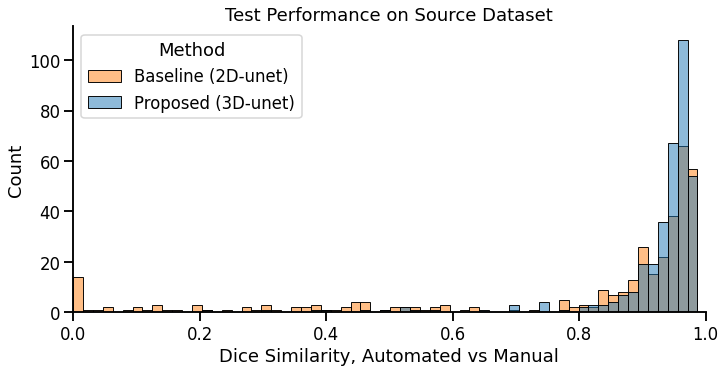

In [9]:

g = sns.displot(data=df, x="dice", hue="group",aspect=2,legend=False,log_scale=(False,False))
plt.legend(title='Method', loc='upper left', labels=['Baseline (2D-unet)','Proposed (3D-unet)'])
g.set_axis_labels("Dice Similarity, Automated vs Manual", "Count")
plt.title('Test Performance on Source Dataset')
plt.xlim(0,1)
g.savefig('figures/dice_ds3090.svg')

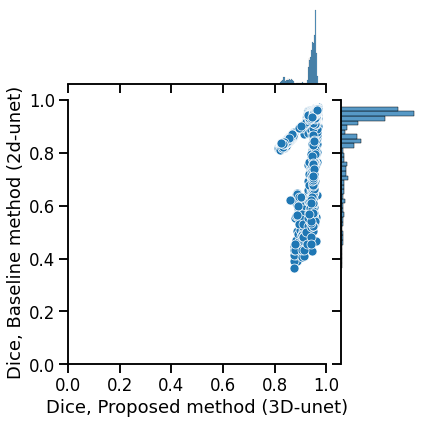

In [10]:
#load up generalization data
df3d = pd.read_csv('https://github.com/akhanf/funcmasker-compare/raw/master/funcmasker_output_uwodata/test_dice.csv',dtype={'voxels_manual':np.int32})
df2d = pd.read_csv('https://github.com/akhanf/funcmasker-compare/raw/master/funcmasker_output_uwodata/test_rutherfordunet_dice.csv',dtype={'voxels_manual':np.int32})

df = pd.merge(df3d,df2d,left_on='id',right_on='id',suffixes=('_nnunet','_rutherford'))

g = sns.jointplot(x='dice_nnunet',y='dice_rutherford',data=df,xlim=(0,1),ylim=(0,1),ratio=3,)
g.set_axis_labels("Dice, Proposed method (3D-unet)", "Dice, Baseline method (2d-unet)")

g.savefig('figures/dice_scatter_localdata.svg')

In [11]:
#make table with mean, stdev, and range
print("\\begin{tabular}{|c|c|c|}")
print(f"Dice metric & $\mu \pm  \sigma$  & (min, max) \\\\")
print(f" Proposed method (3D-unet) & ${df['dice_nnunet'].mean():0.2f} \pm {df['dice_nnunet'].std():0.2f}$ & $({df['dice_nnunet'].min():0.2f},{df['dice_nnunet'].max():0.2f} )$ \\\\")
print(f" Baseline method (2D-unet) & ${df['dice_rutherford'].mean():0.2f} \pm {df['dice_rutherford'].std():0.2f}$ & $({df['dice_rutherford'].min():0.2f},{df['dice_rutherford'].max():0.2f} )$ \\\\")
print("\\end{tabular}")


\begin{tabular}{|c|c|c|}
Dice metric & $\mu \pm  \sigma$  & (min, max) \\
 Proposed method (3D-unet) & $0.93 \pm 0.04$ & $(0.81,0.97 )$ \\
 Baseline method (2D-unet) & $0.87 \pm 0.12$ & $(0.37,0.97 )$ \\
\end{tabular}


In [12]:
#instead of merge, we can concat (while keeping groups separate) to enable overlapping histograms

group = ['Proposed (3D-unet)' for i in range(len(df3d))] + ['Baseline (2D-unet)' for i in range(len(df3d))]
df = pd.concat((df3d,df2d),ignore_index=True)
df['group'] = group
df

,id,voxels_manual,voxels_auto,voxels_overlap,dice,jaccard,group
0,sub-S1_ses-1_task-singing1_vol-0,6647,6606,6348,0.957972,0.919334,Proposed (3D-unet)
1,sub-S1_ses-1_task-singing1_vol-1,6721,6621,6406,0.960276,0.923587,Proposed (3D-unet)
2,sub-S1_ses-1_task-singing1_vol-2,6658,6641,6368,0.957666,0.918771,Proposed (3D-unet)
3,sub-S1_ses-1_task-singing1_vol-3,6834,6590,6400,0.953516,0.911162,Proposed (3D-unet)
4,sub-S1_ses-1_task-singing1_vol-4,6698,6619,6371,0.956822,0.917219,Proposed (3D-unet)
...,...,...,...,...,...,...,...
4395,sub-S10_ses-1_task-rest_vol-105,11386,8657,8657,0.863843,0.760320,Baseline (2D-unet)
4396,sub-S10_ses-1_task-rest_vol-106,11326,8705,8705,0.869153,0.768586,Baseline (2D-unet)
4397,sub-S10_ses-1_task-rest_vol-107,11288,8659,8659,0.868201,0.767098,Baseline (2D-unet)
4398,sub-S10_ses-1_task-rest_vol-108,11319,8629,8629,0.865149,0.762346,Baseline (2D-unet)


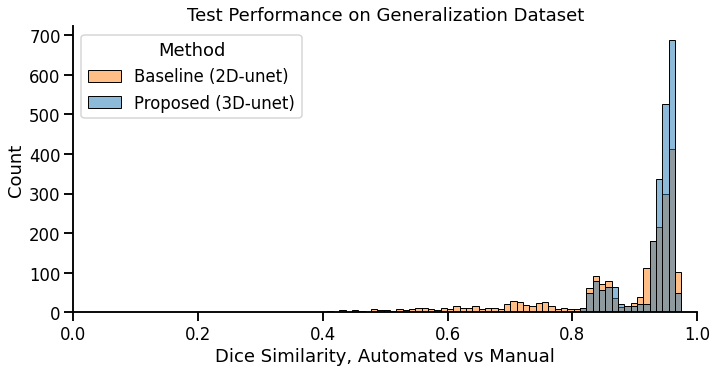

In [13]:
g = sns.displot(data=df, x="dice", hue="group",aspect=2,legend=False,log_scale=(False,False))
plt.legend(title='Method', loc='upper left', labels=['Baseline (2D-unet)','Proposed (3D-unet)'])
g.set_axis_labels("Dice Similarity, Automated vs Manual", "Count")
plt.xlim(0,1)
plt.title('Test Performance on Generalization Dataset')

g.savefig('figures/dice_localdata.svg')

In [14]:
df.voxels_manual

0        6647
1        6721
2        6658
3        6834
4        6698
        ...  
4395    11386
4396    11326
4397    11288
4398    11319
4399    11312
Name: voxels_manual, Length: 4400, dtype: int32

In [15]:
df

,id,voxels_manual,voxels_auto,voxels_overlap,dice,jaccard,group
0,sub-S1_ses-1_task-singing1_vol-0,6647,6606,6348,0.957972,0.919334,Proposed (3D-unet)
1,sub-S1_ses-1_task-singing1_vol-1,6721,6621,6406,0.960276,0.923587,Proposed (3D-unet)
2,sub-S1_ses-1_task-singing1_vol-2,6658,6641,6368,0.957666,0.918771,Proposed (3D-unet)
3,sub-S1_ses-1_task-singing1_vol-3,6834,6590,6400,0.953516,0.911162,Proposed (3D-unet)
4,sub-S1_ses-1_task-singing1_vol-4,6698,6619,6371,0.956822,0.917219,Proposed (3D-unet)
...,...,...,...,...,...,...,...
4395,sub-S10_ses-1_task-rest_vol-105,11386,8657,8657,0.863843,0.760320,Baseline (2D-unet)
4396,sub-S10_ses-1_task-rest_vol-106,11326,8705,8705,0.869153,0.768586,Baseline (2D-unet)
4397,sub-S10_ses-1_task-rest_vol-107,11288,8659,8659,0.868201,0.767098,Baseline (2D-unet)
4398,sub-S10_ses-1_task-rest_vol-108,11319,8629,8629,0.865149,0.762346,Baseline (2D-unet)
